In [2]:
# %pip install ..
# %pip install tme

import math
import jax
import jaxopt
import jax.numpy as jnp
import jax.scipy.optimize
import matplotlib.pyplot as plt
from reflax.data_analysis.chirpgp.models import g, g_inv, build_chirp_model
from reflax.data_analysis.chirpgp.filters_smoothers import ekf, eks
from reflax.data_analysis.chirpgp.quadratures import gaussian_expectation
from reflax.data_analysis.chirpgp.toymodels import gen_chirp, meow_freq, constant_mag, damped_exp_mag, random_ou_mag
from reflax.data_analysis.chirpgp.tools import rmse

jax.config.update("jax_enable_x64", True)

# Times
dt = 0.001
T = 3141
ts = jnp.linspace(dt, dt * T, T)

# Frequency
a = 1
b = 1
true_phase_func = 0.5 * a * ts ** 2 + b * ts
true_freq_func = a * ts + b

# Generate chirp
true_chirp = jnp.sin(2 * jnp.pi * true_phase_func)

# Random keys
key = jax.random.PRNGKey(555)
key, subkey = jax.random.split(key)

# Generate chirp measurements
Xi = 0.001
ys = true_chirp + math.sqrt(Xi) * jax.random.normal(key, shape=(ts.size,))

def chirp_analyzer(chirp_signal):
    # MLE parameter estimation
    # From left to right, they are, lam, b, delta, ell, sigma, m0_1
    init_theta = g_inv(jnp.array([0.1, 0.1, 0.1, 1., 1., 7.]))

    # Objective function
    @jax.jit
    def obj_func(theta: jnp.ndarray):
        _, _, m_and_cov, m0, P0, H = build_chirp_model(g(theta))
        return ekf(m_and_cov, H, Xi, m0, P0, dt, chirp_signal)[-1][-1]

    # Optimise
    opt_solver = jaxopt.ScipyMinimize(method='L-BFGS-B', jit=True, fun=obj_func)
    opt_vals, opt_state = opt_solver.run(init_theta)
    opt_params = g(opt_vals)
    print(f'Parameter learnt: {opt_params}. Convergence: {opt_state}')

    # Filtering and smoothing based on the learnt parameters
    _, _, m_and_cov, m0, P0, H = build_chirp_model(opt_params)

    @jax.jit
    def filtering(measurements):
        return ekf(m_and_cov, H, Xi, m0, P0, dt, measurements)

    @jax.jit
    def smoothing(mfs, Pfs):
        return eks(m_and_cov, mfs, Pfs, dt)

    # Trigger jit
    _dummy = filtering(jnp.ones((2,)))
    smoothing(_dummy[0], _dummy[1])

    filtering_results = filtering(chirp_signal)
    smoothing_results = smoothing(filtering_results[0], filtering_results[1])

    # Note that the distribution of f=g(V) is not Gaussian
    # The confidence interval in the following may not be centred at E[g(V)]
    estimated_freqs_mean = gaussian_expectation(ms=smoothing_results[0][:, 2],
                                                chol_Ps=jnp.sqrt(smoothing_results[1][:, 2, 2]),
                                                func=g, force_shape=True)[:, 0]
    
    return estimated_freqs_mean, smoothing_results

estimated_freqs_mean, smoothing_results = chirp_analyzer(ys)

Parameter learnt: [1.91010862e-03 3.16884625e-08 1.22861517e+00 5.92244789e+01
 1.57950847e+01 2.69517098e-05]. Convergence: ScipyMinimizeInfo(fun_val=Array(-6295.52902289, dtype=float64, weak_type=True), success=True, status=0, iter_num=100, hess_inv=LbfgsInvHessProduct(sk=[[ 3.10659688e-03 -4.13264439e-01 -1.62349593e-03 -1.05396964e-01
   8.52989914e-03 -4.56370490e-01]
 [ 1.30277671e-03 -3.72352025e-01 -2.82879782e-03 -4.21424673e-02
   7.12512102e-03 -4.49129876e-01]
 [ 1.27376923e-03 -4.10923136e-01 -1.36243216e-03  4.48349222e-02
   6.31119786e-03 -5.46505903e-01]
 [ 5.65529971e-04 -3.73363318e-01 -3.66104052e-04  6.90612261e-02
   5.36005071e-04 -5.25532292e-01]
 [ 7.60400686e-04 -3.86016401e-01  5.71401009e-04  5.51665290e-02
  -6.73247638e-04 -5.35464115e-01]
 [-4.83550672e-03 -4.09616730e-01  9.54204042e-04 -9.01903041e-03
  -2.15139226e-03 -5.31477023e-01]
 [-5.09682342e-04 -3.47259206e-01  3.59470146e-04 -1.43745939e-02
  -9.09615906e-04 -4.46914765e-01]
 [-4.57396226e-04 

RMSE:  0.0035008999252934005


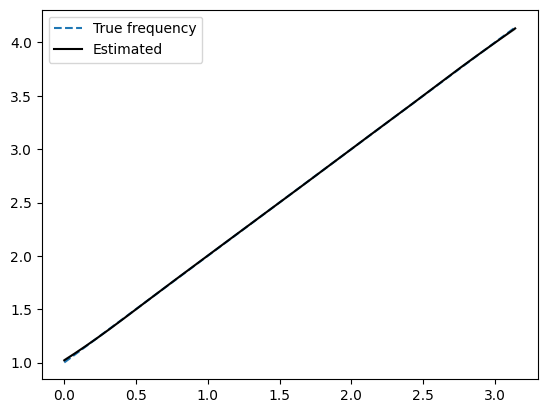

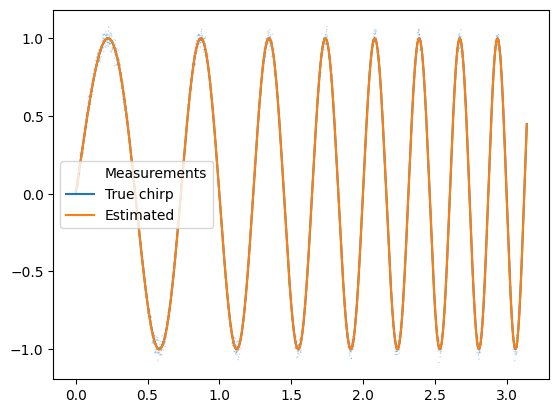

In [3]:
print('RMSE: ', rmse(true_freq_func, estimated_freqs_mean))

# Plot
plt.plot(ts, true_freq_func, c='tab:blue', linestyle='--', label='True frequency')
plt.plot(ts, estimated_freqs_mean, c='black', label='Estimated')
plt.fill_between(ts,
                    g(smoothing_results[0][:, 2] - 1.96 * jnp.sqrt(smoothing_results[1][:, 2, 2])),
                    g(smoothing_results[0][:, 2] + 1.96 * jnp.sqrt(smoothing_results[1][:, 2, 2])),
                    color='black',
                    edgecolor='none',
                    alpha=0.15)
plt.legend()
plt.show()

plt.scatter(ts, ys, s=1, alpha=0.3, c='tab:blue', edgecolors='none', label='Measurements')
plt.plot(ts, true_chirp, label='True chirp')
plt.plot(ts, smoothing_results[0][:, 1], label='Estimated')
plt.legend()
plt.show()

Parameter learnt: [2.83390825e-06 1.25848488e-05 4.52641255e-01 2.54064745e+00
 1.12431426e+01 7.74680951e+00]. Convergence: ScipyMinimizeInfo(fun_val=Array(968.03642073, dtype=float64, weak_type=True), success=True, status=0, iter_num=23, hess_inv=LbfgsInvHessProduct(sk=[[-7.47756200e-01 -5.73401853e-01  1.14515287e-02  1.01503416e-01
   5.41418331e-01 -1.68714143e-01]
 [-3.42421506e+00 -2.65535412e+00  2.41566941e-02  4.76549331e-01
   2.50738217e+00 -5.64636579e-01]
 [-4.75875065e-02  3.22292185e-03  1.57740390e-01  2.80231055e-02
   7.16028723e-02  1.85408080e-02]
 [-1.89305150e-01 -1.76429222e-01 -8.60033344e-03  4.19053608e-02
   1.66584038e-01  9.17736922e-02]
 [-6.83875993e-01 -6.34296812e-01 -8.85375771e-02  8.35203840e-02
   4.74061654e-01  3.26983978e-01]
 [-2.77155047e-01 -2.49546651e-01 -2.76409494e-02  5.12084701e-02
   2.15278611e-01  1.12554871e-01]
 [-2.26600146e-01 -1.93509865e-01 -2.21679007e-02  3.83113042e-02
   1.72637616e-01  2.67753727e-02]
 [-4.45737457e-01 -3.

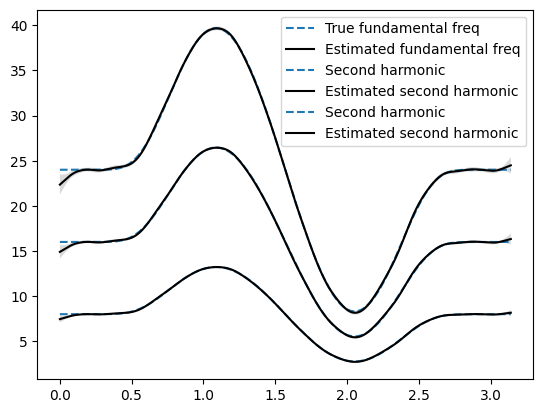

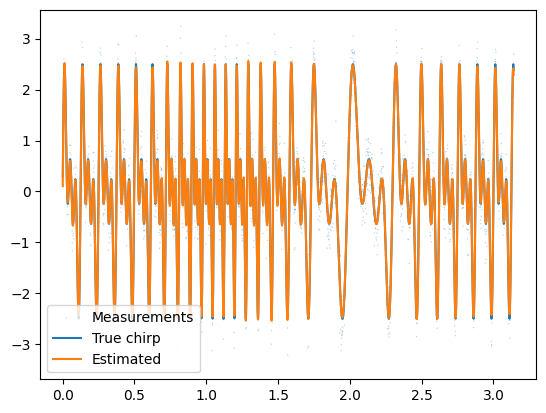

Parameter learnt: [2.89702779e-01 6.81572986e-07 7.68823471e-01 3.00714231e+00
 1.63215609e+01 7.76641162e+00]. Convergence: ScipyMinimizeInfo(fun_val=Array(956.2902492, dtype=float64, weak_type=True), success=True, status=0, iter_num=45, hess_inv=LbfgsInvHessProduct(sk=[[ 2.20902790e-03 -1.10285399e-01 -9.56053126e-03  2.46911328e-02
   1.35432971e-01 -1.35692088e-01]
 [ 3.59656208e-03 -9.52114622e-02 -2.30440743e-02  1.71599641e-02
   1.14908664e-01 -3.40538718e-02]
 [-6.33002174e-04  2.01450028e-02  1.18333298e-02 -2.18301331e-03
  -2.51166717e-02 -9.84470959e-04]
 [ 5.65169346e-06 -7.45662050e-04  1.78157969e-04  4.62952946e-04
   7.23873510e-04  2.51337005e-05]
 [-1.51729841e-02  7.75791759e-01  2.59612921e-01 -2.88673677e-01
  -8.37967724e-01 -5.59371314e-01]
 [-1.79066727e-02  3.43028640e-02  1.08996747e-01  1.29765073e-01
  -6.92394525e-02 -3.05765226e-01]
 [ 2.89228158e-02 -1.25477106e-01 -7.05942640e-02  7.27171148e-03
   1.57566871e-01  3.60293739e-02]
 [-1.28051973e-02 -7.8

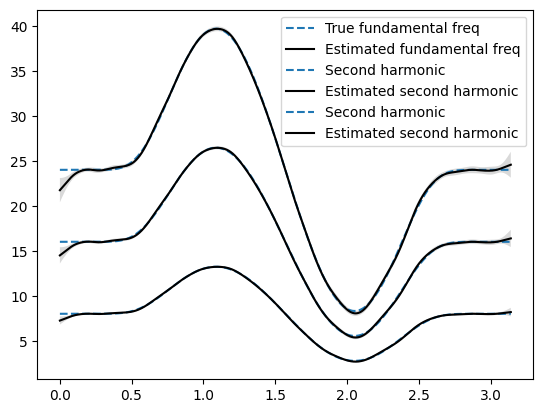

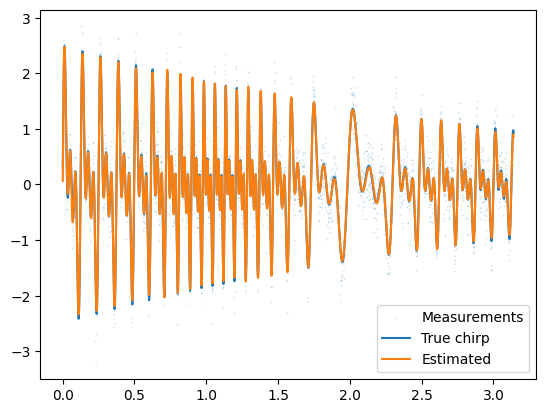

Parameter learnt: [0.24649772 0.98604782 3.54225803 1.4986283  5.76473967 3.90580524]. Convergence: ScipyMinimizeInfo(fun_val=Array(1361.6093167, dtype=float64, weak_type=True), success=True, status=0, iter_num=35, hess_inv=LbfgsInvHessProduct(sk=[[-2.94385056e-02 -3.45236513e-04 -1.24730292e-01  3.06017520e-02
   1.29033902e-01 -3.33950814e-01]
 [-2.71679014e-02 -6.65073427e-03  4.43747999e-02  1.57609385e-02
   1.51405946e-02 -1.24985221e-01]
 [-3.30785716e-02  3.25189445e-03  3.71798220e-03 -6.03659085e-03
   2.91341767e-02 -8.69629207e-03]
 [ 2.27017076e-03 -2.98951583e-04 -8.11079247e-03 -9.37485544e-04
  -7.26333012e-03 -6.89885520e-04]
 [ 3.25570476e-01  2.07973231e-02 -2.89641844e-01  1.19872853e-02
  -1.56462361e-01 -2.15177118e-01]
 [ 5.97230742e-02 -1.76422469e-02  9.49437505e-02  9.29387896e-03
   1.37562469e-01 -2.57757276e-02]
 [-6.09233289e-02 -6.38081789e-03 -9.96980465e-02 -5.52570416e-02
  -1.53195578e-01 -6.95380380e-03]
 [ 4.11957602e-02  1.61684078e-03 -4.10608110e

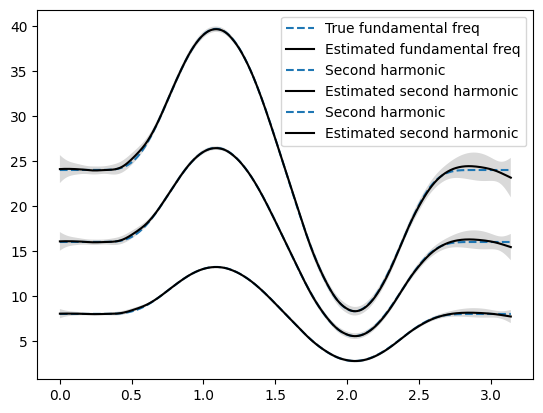

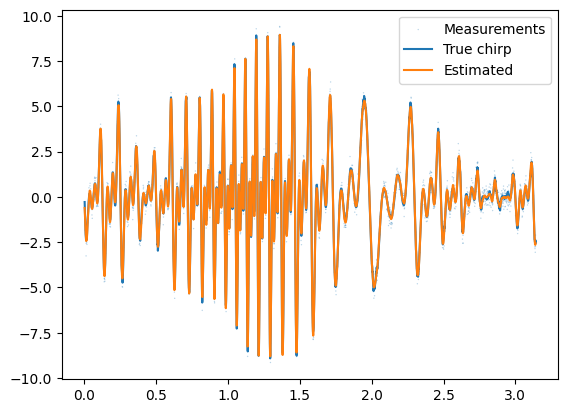

In [4]:
# Times
from reflax.data_analysis.chirpgp.filters_smoothers import sgp_filter, sgp_smoother
from reflax.data_analysis.chirpgp.models import build_harmonic_chirp_model
from reflax.data_analysis.chirpgp.quadratures import SigmaPoints
from reflax.data_analysis.chirpgp.toymodels import gen_harmonic_chirp


dt = 0.001
T = 3141
ts = jnp.linspace(dt, dt * T, T)

# Random keys
key = jax.random.PRNGKey(777)
key, subkey = jax.random.split(key)

# Number of harmonics
num_harmonics = 3

sgps = SigmaPoints.cubature(d=8)

# Frequency
true_freq_func, true_phase_func = meow_freq(offset=8.)

for mag in [constant_mag(1.),
            damped_exp_mag(0.3),
            random_ou_mag(1., 1., subkey)]:

    # Generate chirp
    true_chirp = gen_harmonic_chirp(ts, [mag] * num_harmonics, true_phase_func)

    # Generate chirp measurements
    Xi = 0.1
    ys = true_chirp + math.sqrt(Xi) * jax.random.normal(key, shape=(ts.size,))

    # MLE parameter estimation
    # From left to right, they are, lam, b, delta, ell, sigma, m0_1
    init_theta = g_inv(jnp.array([0.1, 0.1, 0.1, 1., 1., 7.]))

    # Objective function
    @jax.jit
    def obj_func(theta: jnp.ndarray):
        _, _, m_and_cov, m0, P0, H = build_harmonic_chirp_model(g(theta), num_harmonics=num_harmonics)
        return sgp_filter(m_and_cov, sgps, H, Xi, m0, P0, dt, ys)[-1][-1]

    # Optimise
    opt_solver = jaxopt.ScipyMinimize(method='L-BFGS-B', jit=True, fun=obj_func)
    opt_vals, opt_state = opt_solver.run(init_theta)
    opt_params = g(opt_vals)
    print(f'Parameter learnt: {opt_params}. Convergence: {opt_state}')

    # Filtering and smoothing based on the learnt parameters
    _, _, m_and_cov, m0, P0, H = build_harmonic_chirp_model(opt_params, num_harmonics=num_harmonics)

    @jax.jit
    def filtering(measurements):
        return sgp_filter(m_and_cov, sgps, H, Xi, m0, P0, dt, measurements)

    @jax.jit
    def smoothing(mfs, Pfs):
        return sgp_smoother(m_and_cov, sgps, mfs, Pfs, dt)

    # Trigger jit
    _dummy = filtering(jnp.ones((2,)))
    smoothing(_dummy[0], _dummy[1])

    filtering_results = filtering(ys)
    smoothing_results = smoothing(filtering_results[0], filtering_results[1])

    # Note that the distribution of f=g(V) is not Gaussian
    # The confidence interval in the following may not be centred at E[g(V)]
    estimated_freqs_mean = gaussian_expectation(ms=smoothing_results[0][:, -2],
                                                chol_Ps=jnp.sqrt(smoothing_results[1][:, -2, -2]),
                                                func=g, force_shape=True)[:, 0]

    print('RMSE: ', rmse(true_freq_func(ts), estimated_freqs_mean))

    # Plot
    plt.plot(ts, true_freq_func(ts), c='tab:blue', linestyle='--', label='True fundamental freq')
    plt.plot(ts, estimated_freqs_mean, c='black', label='Estimated fundamental freq')
    plt.fill_between(ts,
                     g(smoothing_results[0][:, -2] - 1.96 * jnp.sqrt(smoothing_results[1][:, -2, -2])),
                     g(smoothing_results[0][:, -2] + 1.96 * jnp.sqrt(smoothing_results[1][:, -2, -2])),
                     color='black',
                     edgecolor='none',
                     alpha=0.15)

    plt.plot(ts, 2 * true_freq_func(ts), c='tab:blue', linestyle='--', label='Second harmonic')
    plt.plot(ts, 2 * estimated_freqs_mean, c='black', label='Estimated second harmonic')
    plt.fill_between(ts,
                     2 * g(smoothing_results[0][:, -2] - 1.96 * jnp.sqrt(smoothing_results[1][:, -2, -2])),
                     2 * g(smoothing_results[0][:, -2] + 1.96 * jnp.sqrt(smoothing_results[1][:, -2, -2])),
                     color='black',
                     edgecolor='none',
                     alpha=0.15)

    plt.plot(ts, 3 * true_freq_func(ts), c='tab:blue', linestyle='--', label='Second harmonic')
    plt.plot(ts, 3 * estimated_freqs_mean, c='black', label='Estimated second harmonic')
    plt.fill_between(ts,
                     3 * g(smoothing_results[0][:, -2] - 1.96 * jnp.sqrt(smoothing_results[1][:, -2, -2])),
                     3 * g(smoothing_results[0][:, -2] + 1.96 * jnp.sqrt(smoothing_results[1][:, -2, -2])),
                     color='black',
                     edgecolor='none',
                     alpha=0.15)

    plt.legend()
    plt.show()

    plt.scatter(ts, ys, s=1, alpha=0.3, c='tab:blue', edgecolors='none', label='Measurements')
    plt.plot(ts, true_chirp, label='True chirp')
    plt.plot(ts, smoothing_results[0] @ H, label='Estimated')
    plt.legend()
    plt.show()